In [1]:
%autosave 100

Autosaving every 100 seconds


Import all neccessary libraries

In [2]:
import numpy as np
import pandas as pd

# for PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from jupyterplot import ProgressPlot

# for classification with cross-validation
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Define utility functions

In [3]:
def load_dataset():
    labels = pd.read_csv("data/Class_labels.txt", sep="\t", header=0, index_col=1)

    df_list = [pd.read_csv("features_cd/vectors/" + file + ".breadth", header=None, index_col=None) for file in labels.index]
    data = pd.concat(df_list, axis=1)
    data.columns=labels.index
    data_cd = data.T

    df_list = [pd.read_csv("features_uc/vectors/" + file + ".breadth", header=None, index_col=None) for file in labels.index]
    data = pd.concat(df_list, axis=1)
    data.columns=labels.index
    data_uc = data.T
    
    df_list = [pd.read_csv("features_nonibd/vectors/" + file + ".breadth", header=None, index_col=None) for file in labels.index]
    data = pd.concat(df_list, axis=1)
    data.columns=labels.index
    data_nonibd = data.T
    
    data = pd.concat([data_cd, data_uc, data_nonibd], axis=1, ignore_index=True)
    lbls = np.array([labels.loc[i, "group"] for i in data.index])

    return data, lbls

Apply PCA to data

In [4]:
data, labels = load_dataset()
pca = PCA(n_components=2)
values = pca.fit_transform(data)

Create PCA plot

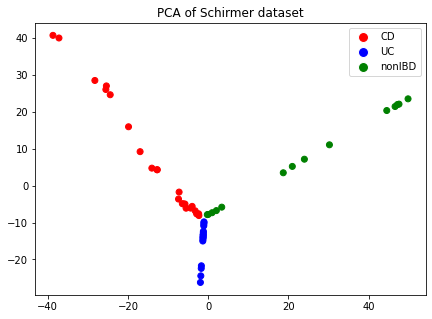

In [5]:
colors = dict(zip(['CD', 'UC', 'nonIBD'], ['r', 'b', 'g']))

plt.figure(figsize=(7, 5))

plt.scatter(values[:, 0], values[:, 1], color=[colors[i] for i in labels])
legend_elements = [Line2D([], [], marker='o', color='w', label='CD', markerfacecolor='r', markersize=10),
                   Line2D([], [], marker='o', color='w', label='UC', markerfacecolor='b', markersize=10),
                   Line2D([], [], marker='o', color='w', label='nonIBD', markerfacecolor='g', markersize=10)]

plt.legend(handles=legend_elements)
plt.title("PCA of Schirmer dataset")
plt.show()

PCA shows good separation of samples into three categories.
Now let's try to train Neural Network classification model.

In the beginning, we need to define model. We will use [PyTorch](https://pytorch.org/) library.

In [6]:
class SingleLayer(nn.Module):
    def __init__(self, c_in, c_out, drop=0.0):
        super(SingleLayer, self).__init__()

        self.lin = nn.Linear(c_in, c_out)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        z = self.drop(self.relu(self.lin(x)))
        return z

    
class FeedForwardNet(nn.Module):
    def __init__(self, c_in, c_out, drop=0.0):
        super(FeedForwardNet, self).__init__()

        self.seq = nn.Sequential()
        base = np.array([4096, 1024, 256, 64, 16])
        out = [c_in] + list(base[base<c_in])
        for i in range(len(out)-1):
            self.seq.add_module(str(i), SingleLayer(out[i], out[i+1], drop))

        self.convLast = nn.Linear(out[-1], c_out)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        z = self.seq(x)
        z = self.logsoftmax(self.convLast(z))
        return z

class NeuralNetwork():
    def __init__(self, c_in, c_out, epochs=100, drop=0.0, bs=32):
        self.model = FeedForwardNet(c_in=c_in, c_out=c_out, drop=drop)
        if torch.cuda.is_available():
            print("Using cuda")
            self.model.cuda()
        else:
            print("Using cpu")
        
        self.opt = optim.Adam(self.model.parameters())
        self.loss = nn.NLLLoss()
        self.epochs=epochs
        self.bs = bs
        
    def train_epoch(self, X_train, y_train):
        self.model.train(True)

        sum_ = 0
        for i in range(0, X_train.shape[0], self.bs):
            X = X_train[i:i+self.bs]
            y = y_train[i:i+self.bs]

            X, y = torch.from_numpy(X.to_numpy()).float(), torch.from_numpy(y).long()

            if torch.cuda.is_available():
                X = X.cuda()
                y = y.cuda()

            self.opt.zero_grad()
            y_ = self.model(X)
            loss_value = self.loss(y_, y)
            loss_value.backward()
            self.opt.step()
            _, y_ = torch.max(y_, axis=1)
            sum_ += torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        return sum_ / X_train.shape[0]
    

    
    def fit(self, X_train, y_train):
        pp = ProgressPlot(x_lim=[0, self.epochs-1], y_lim=[0, 1], plot_names=["Accuracy"], line_names=['train curve', 'eval curve'], line_colors=['green', 'red'])
        X_tr, X_eval, y_tr, y_eval = train_test_split(X_train, y_train, test_size=0.5)
        for epoch in range(self.epochs):
            accuracy_train = self.train_epoch(X_tr, y_tr).item()
            accuracy_eval  = self.eval_(X_eval, y_eval).item()
            pp.update([[accuracy_train, accuracy_eval]])
        pp.finalize()
        
        
    def eval_(self, X_test, y_test):
        self.model.train(False)
        
        sum_ = 0
        for i in range(0, X_test.shape[0], self.bs):
            X = X_test[i:i+self.bs]
            y = y_test[i:i+self.bs]

            X, y = torch.from_numpy(X.to_numpy()).float(), torch.from_numpy(y).long()

            if torch.cuda.is_available():
                X = X.cuda()
                y = y.cuda()

            y_ = self.model(X)
            _, y_ = torch.max(y_, axis=1)
            sum_ += torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        return sum_ / X_test.shape[0]
    
    
    def predict(self, X_test):
        self.model.train(False)
        
        ans = []
        for i in range(0, X_test.shape[0], self.bs):
            X = X_test[i:i+self.bs]
            
            X = torch.from_numpy(X.to_numpy()).float()

            if torch.cuda.is_available():
                X = X.cuda()

            y_ = self.model(X)
            _, y_ = torch.max(y_, axis=1)
            ans += list(y_.cpu().numpy())
        return ans

Firstly, let's deal with 3-class problem and get accuracy using KFold splits.

Fold #1
Using cuda


Fold #2
Using cuda


Fold #3
Using cuda


Fold #4
Using cuda


Fold #5
Using cuda


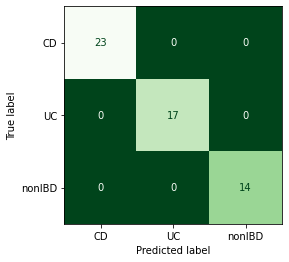

Accuracy: 1.0


In [7]:
def encode(y):
    return 0 if y=='CD' else 1 if y=='UC' else 2

def decode(y):
    return 'CD' if y==0 else 'UC' if y==1 else 'nonIBD'


data, labels = load_dataset()

cv = StratifiedKFold(n_splits=5)

accs = []
y_tests = []
y_preds = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    print(f"Fold #{i+1}")
    model = NeuralNetwork(data.shape[1], len(np.unique(labels)), epochs=11)
    X_train, X_test = data.iloc[train, :], data.iloc[test, :]
    y_train, y_test = labels[train], labels[test]
    model.fit(X_train, np.array([encode(i) for i in y_train]))
    y_pred = model.predict(X_test)
    
    y_pred = np.array([decode(i) for i in y_pred])
    
    accs.append(accuracy_score(y_test, y_pred))
    y_tests.extend(y_test)
    y_preds.extend(y_pred)
    
ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, labels=['CD', 'UC', 'nonIBD'], colorbar=False, cmap='Greens_r')
plt.show()
    
print("Accuracy:", round(accuracy_score(y_tests, y_preds), 2))

Secondly, let's examine in details 2-class IBD vs nonIBD problem

Fold #1
Using cuda


Fold #2
Using cuda


Fold #3
Using cuda


Fold #4
Using cuda


Fold #5
Using cuda


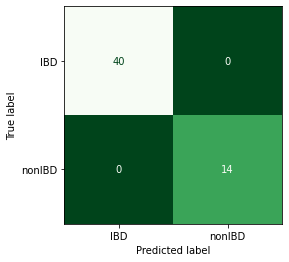

Accuracy: 1.0


In [8]:
def encode(y):
    return 0 if y=='IBD' else 1

def decode(y):
    return 'IBD' if y==0 else 'nonIBD'


data, labels = load_dataset()
labels = np.where(~np.isin(labels, ['CD', 'UC']), labels, 'IBD')

cv = StratifiedKFold(n_splits=5)

accs = []
y_tests = []
y_preds = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    print(f"Fold #{i+1}")
    model = NeuralNetwork(data.shape[1], len(np.unique(labels)), epochs=11)
    X_train, X_test = data.iloc[train, :], data.iloc[test, :]
    y_train, y_test = labels[train], labels[test]
    model.fit(X_train, np.array([encode(i) for i in y_train]))
    y_pred = model.predict(X_test)
    
    y_pred = np.array([decode(i) for i in y_pred])
    
    accs.append(accuracy_score(y_test, y_pred))
    y_tests.extend(y_test)
    y_preds.extend(y_pred)
    
ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, labels=['IBD', 'nonIBD'], colorbar=False, cmap='Greens_r')
plt.show()
    
print("Accuracy:", round(accuracy_score(y_tests, y_preds), 2))

Finally, let's examine in details 2-class CD vs UC problem

Fold #1
Using cuda


Fold #2
Using cuda


Fold #3
Using cuda


Fold #4
Using cuda


Fold #5
Using cuda


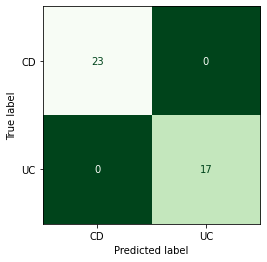

Accuracy: 1.0


In [9]:
def encode(y):
    return 0 if y=='CD' else 1

def decode(y):
    return 'CD' if y==0 else 'UC'


data, labels = load_dataset()
i = np.where(np.isin(labels, ['CD', 'UC']))[0]
data = data.iloc[i, :]
labels = labels[i]

cv = StratifiedKFold(n_splits=5)

accs = []
y_tests = []
y_preds = []

for i, (train, test) in enumerate(cv.split(data, labels)):
    print(f"Fold #{i+1}")
    model = NeuralNetwork(data.shape[1], len(np.unique(labels)), epochs=11)
    
    X_train, X_test = data.iloc[train, :], data.iloc[test, :]
    y_train, y_test = labels[train], labels[test]
    model.fit(X_train, np.array([encode(i) for i in y_train]))
    y_pred = model.predict(X_test)
    
    y_pred = np.array([decode(i) for i in y_pred])
    
    accs.append(accuracy_score(y_test, y_pred))
    y_tests.extend(y_test)
    y_preds.extend(y_pred)
    
ConfusionMatrixDisplay.from_predictions(y_tests, y_preds, labels=['CD', 'UC'], colorbar=False, cmap='Greens_r')
plt.show()
    
print("Accuracy:", round(accuracy_score(y_tests, y_preds), 2))